In [ ]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
np.random.seed(42)
random.seed(42)

In [ ]:
train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv',index_col=0)

In [ ]:
train['text_lemmatized_list'] = train['text_lemmatized'].apply(lambda x: x.replace('[\'','').replace('\']','').split('\', \''))
test['text_lemmatized_list'] = test['text_lemmatized'].apply(lambda x: x.replace('[\'','').replace('\']','').split('\', \''))

Unigrams, bigrams, trigrams

In [ ]:
bow_converter = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
x = bow_converter.fit_transform(train['text_lemmatized_list'])

words = bow_converter.get_feature_names()
len(words)

118362

In [ ]:
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase=False) 
x2 = bigram_converter.fit_transform(train['text_lemmatized_list'])
bigrams = bigram_converter.get_feature_names()
len(bigrams)

2111657

In [ ]:
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False) 
x3 = trigram_converter.fit_transform(train['text_lemmatized_list'])
trigrams = trigram_converter.get_feature_names()
len(trigrams)

4299601

In [ ]:
print(len(words), len(bigrams), len(trigrams))

118362 2111657 4299601


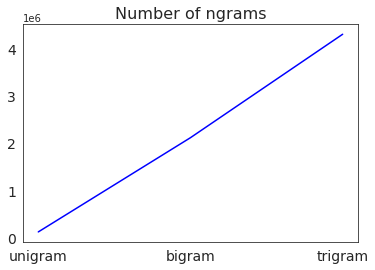

In [ ]:
counts = [len(words), len(bigrams), len(trigrams)]
plt.plot(counts, color='blue')
plt.xticks(range(3), ['unigram', 'bigram', 'trigram'])
plt.tick_params(labelsize=14)
plt.title('Number of ngrams', {'fontsize':16})
plt.show()

Bag of words

In [ ]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False) 
X_tr_bow = bow_transform.fit_transform(train['text_lemmatized_list'])
len(bow_transform.vocabulary_)

4299601

In [ ]:
X_te_bow = bow_transform.transform(test['text_lemmatized_list'])

In [ ]:
y_tr = train['label']
y_te = test['label']

Tf-Idf Transformation

In [ ]:
tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_transform.transform(X_te_bow)

Classification with Logistic Regression

In [ ]:
model_bow = LogisticRegression().fit(X_tr_bow, y_tr)
model_tfidf = LogisticRegression().fit(X_tr_tfidf, y_tr)

In [ ]:
print('Test f1_score macro (BoW) - ', f1_score(y_te,model_bow.predict(X_te_bow),average='macro'))
print('Test f1_score micro (BoW) - ', f1_score(y_te,model_bow.predict(X_te_bow),average='micro'))


Test f1_score macro (BoW) -  0.36535272052390466
Test f1_score micro (BoW) -  0.5544945711428988


In [ ]:
print('Test f1_score macro(Tf-Idf) - ', f1_score(y_te,model_tfidf.predict(X_te_tfidf),average='macro'))
print('Test f1_score micro(Tf-Idf) - ', f1_score(y_te,model_tfidf.predict(X_te_tfidf),average='micro'))

Test f1_score macro(Tf-Idf) -  0.4119983110000221
Test f1_score micro(Tf-Idf) -  0.551773862100498


In [ ]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
bow_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5,
                                   param_grid=param_grid_)

In [ ]:
bow_search.fit(X_tr_bow, y_tr)

In [ ]:
tfidf_search.fit(X_tr_tfidf, y_tr)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]})

In [ ]:
search_results = pd.DataFrame.from_dict({'bow': bow_search.cv_results_['mean_test_score'],
                               'tfidf': tfidf_search.cv_results_['mean_test_score']})
search_results

,bow,tfidf
0,0.507939,0.516366
1,0.516284,0.548880
2,0.544980,0.547969
3,0.551304,0.546274
4,0.550835,0.543193
5,0.549272,0.541708


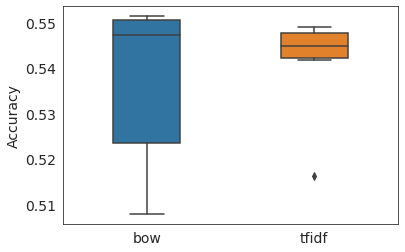

In [ ]:
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)
plt.savefig('tfidf_gridcv_results.png')